In [2]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

In [3]:
import numpy as np
import cupy as cp
import gc
import matplotlib.pyplot as plt
from corrcal import sparse
from zp_puregpu_funcs_py import *
from invcov import *

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


### Timing tests for single (large) baseline configuration

In [10]:
#the main parametes describing our problem.
n_bl = 200000
n_eig = 5
n_src = 10
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64') + 0.1   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

In [11]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

In [12]:
test_results = str(benchmark(inverse_covariance, (sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges, xp, True, True), n_repeat=100))
test_results = test_results.split()
cpu_t = float(test_results[3])/1e6
gpu_t = float(test_results[14])/1e6
print(f"Time on cpu: {cpu_t:.6f}s")
print(f"Time on gpu: {gpu_t:.6f}s")

Time on cpu: 0.002366s
Time on gpu: 0.060057s


### Timing tests for an array of baselines

In [40]:
# bl_array = (cp.linspace(3, 120000, 250)).astype(int)
bl_array = (cp.logspace(1, 5.5, 65, base=10)).astype(int)
print(bl_array)

n_eig = 10
n_src = 15
xp = cp  #run things on the gpu using cupy

noise_mats = []
diff_mats = []
src_mats = []
edges_arr = []

for bl in bl_array:
    bl = int(bl)
    edges = xp.unique(xp.random.randint(1, bl-1, size = max(int(np.sqrt(bl)), 1)))
    edges = xp.concatenate((xp.array([0]), edges, xp.array([bl])))
    # print(f"The edges of the redundant blocks have indices{edges}")

    #some random noise, diffuse, and source covariance matrices
    sim_noise_mat = xp.random.rand(bl) + 0.1   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(bl, n_eig)
    sim_src_mat = xp.random.rand(bl, n_src)

    #zeropad the noise, diff, source mats
    zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
    zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
    zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
    zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

    #Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
    sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
    sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
    sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

    noise_mats.append(sim_noise_mat_2d)
    diff_mats.append(sim_diff_mat_3d)
    src_mats.append(sim_src_mat_3d)
    edges_arr.append(edges)

[    10     11     13     16     19     22     26     31     36     42
     50     59     69     82     96    113    133    156    184    216
    254    299    352    414    486    572    673    791    930   1094
   1286   1512   1778   2090   2458   2890   3398   3995   4697   5523
   6493   7635   8976  10554  12409  14590  17154  20169  23713  27881
  32781  38542  45315  53279  62643  73652  86596 101815 119708 140746
 165481 194564 228757 268959 316227]


In [41]:
gpu_times3 = cp.array([])
cpu_times = cp.array([])
for i, (noise, diff_mat, src_mat, edges_mat) in enumerate(zip(noise_mats, diff_mats, src_mats, edges_arr)):
    print(f"Printing iter {i}")
    test_results = str(benchmark(inverse_covariance, (noise, diff_mat, src_mat, edges_mat, xp, True, True), n_repeat=10))
    # cp.cuda.Stream.null.synchronize()
    test_results = test_results.split()
    cpu_t = float(test_results[3])/1e6
    gpu_t = float(test_results[14])/1e6
    print(f"Time on cpu: {cpu_t:.6f}s")
    print(f"Time on gpu: {gpu_t:.6f}s")
    gpu_times3 = cp.append(gpu_times3, gpu_t)
    cpu_times = cp.append(cpu_times, cpu_t)
    cp._default_memory_pool.free_all_blocks()  # Free all unused memory blocks
    gc.collect()  # Run garbage collector

Printing iter 0
Time on cpu: 0.001885s
Time on gpu: 0.001882s
Printing iter 1
Time on cpu: 0.001546s
Time on gpu: 0.001598s
Printing iter 2
Time on cpu: 0.001253s
Time on gpu: 0.001329s
Printing iter 3
Time on cpu: 0.001391s
Time on gpu: 0.001450s
Printing iter 4
Time on cpu: 0.001547s
Time on gpu: 0.001644s
Printing iter 5
Time on cpu: 0.001387s
Time on gpu: 0.001549s
Printing iter 6
Time on cpu: 0.001444s
Time on gpu: 0.001581s
Printing iter 7
Time on cpu: 0.001404s
Time on gpu: 0.001553s
Printing iter 8
Time on cpu: 0.001636s
Time on gpu: 0.001849s
Printing iter 9
Time on cpu: 0.001534s
Time on gpu: 0.001695s
Printing iter 10
Time on cpu: 0.001375s
Time on gpu: 0.001584s
Printing iter 11
Time on cpu: 0.001510s
Time on gpu: 0.001813s
Printing iter 12
Time on cpu: 0.001342s
Time on gpu: 0.001764s
Printing iter 13
Time on cpu: 0.001559s
Time on gpu: 0.002010s
Printing iter 14
Time on cpu: 0.001500s
Time on gpu: 0.001959s
Printing iter 15
Time on cpu: 0.001421s
Time on gpu: 0.002023s
Pr

Text(0, 0.5, 'Time (s)')

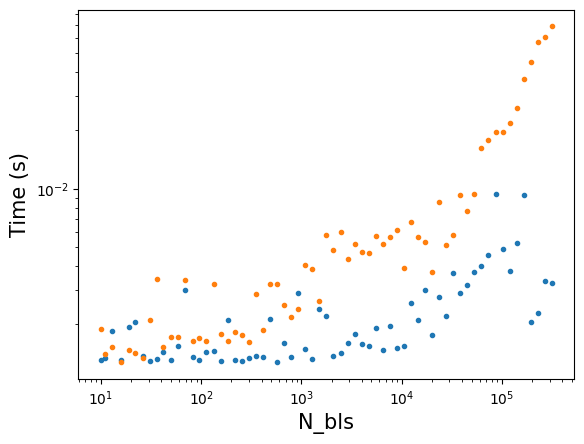

In [ ]:
plt.loglog(cp.asnumpy(bl_array), cp.asnumpy(gpu_times), '.')
plt.loglog(cp.asnumpy(bl_array), cp.asnumpy(gpu_times1), '.')

# plt.plot(cp.asnumpy(bl_array), cp.asnumpy(gpu_times), '.')
plt.xlabel("N_bls", fontsize = 15)
plt.ylabel("Time (s)", fontsize = 15)